In [3]:
import numpy as np
import pandas as pd
import xarray as xr

from datetime import datetime

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [4]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

def bias(x, y): return np.mean(x - y)

def get_stats(x, y):
    warnings.filterwarnings("ignore", message="An input array is constant")
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    if type(x) == list: x = np.array(x)
    if type(y) == list: y = np.array(y)
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)
    return r, b, mae, rmse

In [18]:
from metloom.pointdata import SnotelPointData

snotel_point = SnotelPointData("312:ID:SNTL", "Banner")
df = snotel_point.get_daily_data(
    datetime(2020, 11, 25), datetime(2021, 3, 15),
    [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH, snotel_point.ALLOWED_VARIABLES.SWE]
)
df =df.droplevel('site')

/tmp/ipykernel_23095/210839439.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation =0)


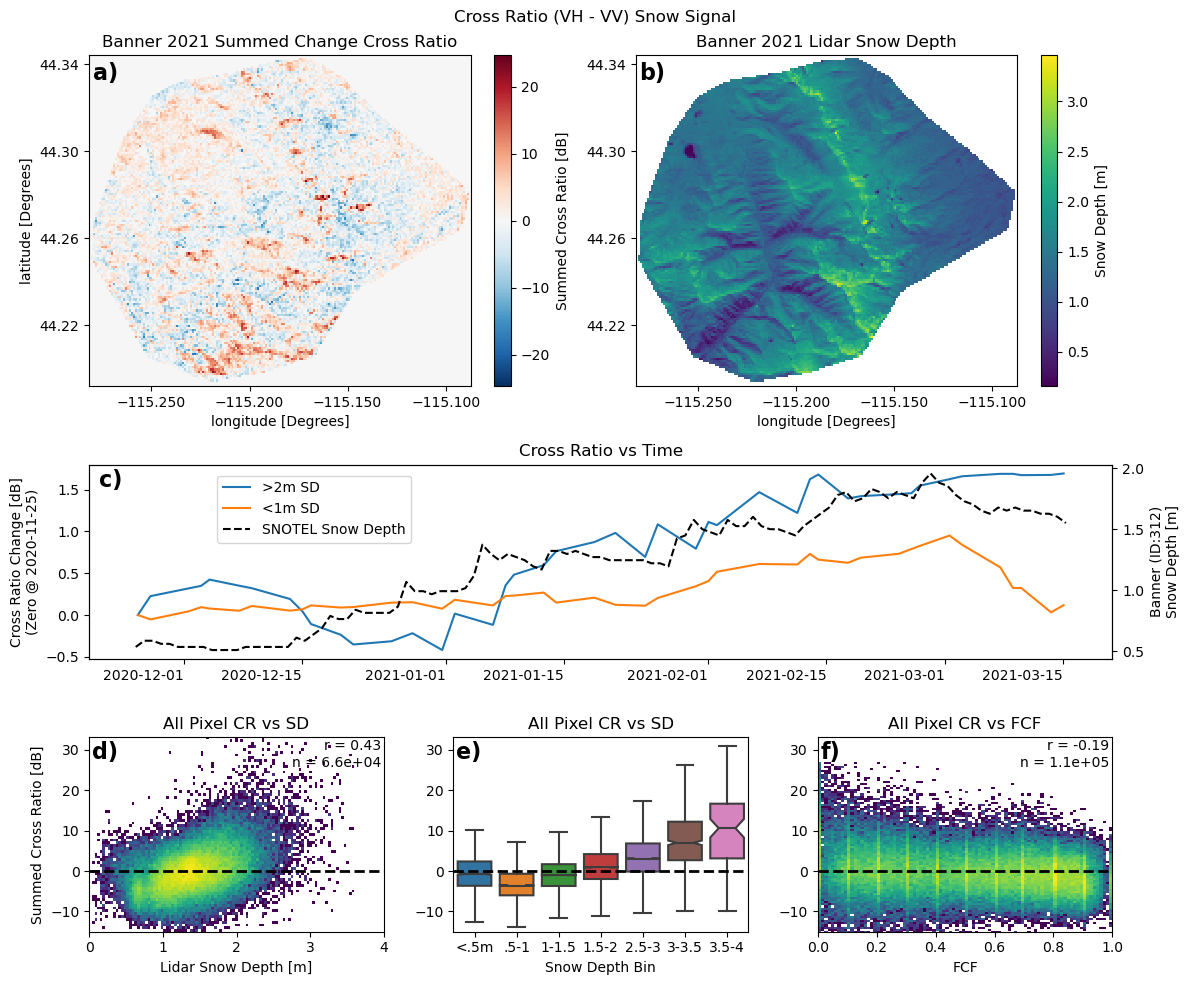

In [66]:
loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}


in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

fig = plt.figure(figsize= (12, 10))
fig.suptitle("Cross Ratio (VH - VV) Snow Signal")

gs1 = GridSpec(7, 6)
ax1 = fig.add_subplot(gs1[:3, :3])
ax2 = fig.add_subplot(gs1[:3, 3:])
ax3 = fig.add_subplot(gs1[3:5, :])
ax4 = fig.add_subplot(gs1[5:, :2])
ax6 = fig.add_subplot(gs1[5:, 2:4])
ax5 = fig.add_subplot(gs1[5:, 4:])

# ax5 = fig.add_subplot(gs1[2, 1:])

ds = dss['Banner_2021-03-15']
ds.x.attrs['units'] = 'Degrees'
ds.y.attrs['units'] = 'Degrees'
ds['deltaCR'].where((ds['ims'] == 4) & (~ds['lidar-sd'].isnull())).sum('time').plot(ax = ax1, cbar_kwargs = {'label':'Summed Cross Ratio [dB]'})
ax1.set_xticks(ax1.get_xticks()[2::2], ax1.get_xticklabels()[2::2])
ax1.set_yticks(ax1.get_yticks()[2::2], ax1.get_yticklabels()[2::2])
ds['lidar-sd'].plot(ax = ax2, cbar_kwargs = {'label':'Snow Depth [m]'})
ax2.set_xticks(ax2.get_xticks()[2::2], ax2.get_xticklabels()[2::2])
ax2.set_yticks(ax2.get_yticks()[2::2], ax2.get_yticklabels()[2::2])
ax2.set_ylabel('')


ds['CR'] = ds['s1'].sel(band = 'VH') - ds['s1'].sel(band = 'VV')
ds = ds.sel(time = slice(f'2020-11-15', '2021-03-15'))

hsd = ds['CR'].where(ds['lidar-sd'] > 2).mean(['x', 'y']).rolling(time = 5).mean().dropna('time')
lsd = ds['CR'].where(ds['lidar-sd'] < 1).mean(['x', 'y']).rolling(time = 5).mean().dropna('time')

(hsd - hsd.sel(time = '2020-11-25', method = 'nearest').mean()).plot(ax = ax3, color = 'C0')
(lsd - lsd.sel(time = '2020-11-25', method = 'nearest').mean()).plot(ax = ax3, color = 'C1')

ax3.plot([], [], color = 'C0', label = '>2m SD')
ax3.plot([], [], color = 'C1', label = '<1m SD')
ax3.plot([], [], color = 'black', label = 'SNOTEL Snow Depth', linestyle ='dashed')

ax3_r =ax3.twinx()
sd_m = (df['SNOWDEPTH']*0.0254)
sd_m.plot(ax = ax3_r,color='black', linestyle = 'dashed')
# ax3_r.set_ylim(0.2, 2.1)

xs, ys = [], []
for name, ds in dss.items():
    x = ds['lidar-sd'].data.ravel()
    y = ds['deltaCR'].where((ds['ims'] == 4)).sum(['time']).data.ravel()
    idx = ~np.isnan(x) & ~np.isnan(y) & (y != 0)
    x, y = x[idx], y[idx]
    xs.extend(x)
    ys.extend(y)

r = get_stats(xs, ys)[0]
n = len(xs)
ax4.text(.99, .99, f'r = {r:.2f}\nn = {n:.1e}', ha = 'right', va = 'top', transform = ax4.transAxes)
ax4.hist2d(xs, ys, alpha = 1, label = name.split('-')[0], norm = mpl.colors.LogNorm(), bins=100, range = [[0,3.6], [-20, 50]]) # , color = loc_colors[name],
ax4.set_xlim(right = 4)
ax4.set_title('All Pixel CR vs SD')
ax4.axhline(0, linestyle ='dashed',color='k', linewidth = 2)

x_y_df = pd.DataFrame(np.column_stack([xs, ys]), columns = ['snow_depth', 'CR'])
bins = np.arange(0, 4, 0.5)
x_y_df['sd_bin'] = pd.cut(x_y_df.snow_depth, bins, labels = ['<.5m', '.5-1', '1-1.5', '1.5-2','2.5-3','3-3.5','3.5-4'])
sns.boxplot(x_y_df, x = 'sd_bin', y = 'CR', ax = ax6, showmeans = False, showfliers = False, notch = True)
kwargs = {'alpha':0}
# sns.barplot(x="sd_bin", y="CR", data=x_y_df, capsize=.1, n_boot=1000, errorbar=('ci', 95), errwidth=2,ax = ax6, **kwargs)
ax6.axhline(0, linestyle ='dashed',color='k', linewidth = 2)
ax6.set_title('All Pixel CR vs SD')
ax6.set_ylabel('')
ax6.set_xlabel('Snow Depth Bin')


xs, ys = [], []
for name, ds in dss.items():
    x = ds['fcf'].data.ravel()
    y = ds['deltaCR'].where((ds['ims'] == 4)).sum(['time']).data.ravel()
    idx = ~np.isnan(x) & ~np.isnan(y) & (y != 0)
    x, y = x[idx], y[idx]
    xs.extend(x)
    ys.extend(y)

r = get_stats(xs, ys)[0]
n = len(xs)
ax5.text(.99, .99, f'r = {r:.2f}\nn = {n:.1e}', ha = 'right', va = 'top', transform = ax5.transAxes)
ax5.hist2d(xs, ys, alpha = 1, label = name.split('-')[0], norm = mpl.colors.LogNorm(), bins=90, range = [[0,1],[-20,27]]) # , color = loc_colors[name],
# ax5.set_xlim(right = 4)
ax5.set_title('All Pixel CR vs FCF')
ax5.axhline(0, linestyle ='dashed',color='k', linewidth = 2)
ax5.set_xlabel('FCF')

for ax in [ax4,ax5,ax6]:
    ax.set_ylim(-15, 33)

for ax, letter in zip([ax1, ax2,ax3, ax4, ax6, ax5], ['a', 'b','c','d','e','f']):
    if letter == 'f':
        ax.text(0.01, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)
    else:
        ax.text(0.01, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)

ax1.set_title('Banner 2021 Summed Change Cross Ratio')
ax2.set_title('Banner 2021 Lidar Snow Depth')

axbox = ax3.get_position()
x_value = 0.0
y_value= 0.2
# fig.legend([line1], ["cos"], loc = (axbox.x0 + x_value, axbox.y0 + y_value))
ax3.legend(loc = (axbox.x0 + x_value, axbox.y0 + y_value))

ax3.set_title('Cross Ratio vs Time')
ax3.set_xlabel('')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation =0)
ax3.set_ylabel('Cross Ratio Change [dB]\n(Zero @ 2020-11-25)')
ax3_r.set_ylabel('Banner (ID:312)\nSnow Depth [m]')
ax4.set_xlabel('Lidar Snow Depth [m]')
ax4.set_ylabel('Summed Cross Ratio [dB]')
plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/spicy-analysis/figures/cr/banner2021_cr.png')

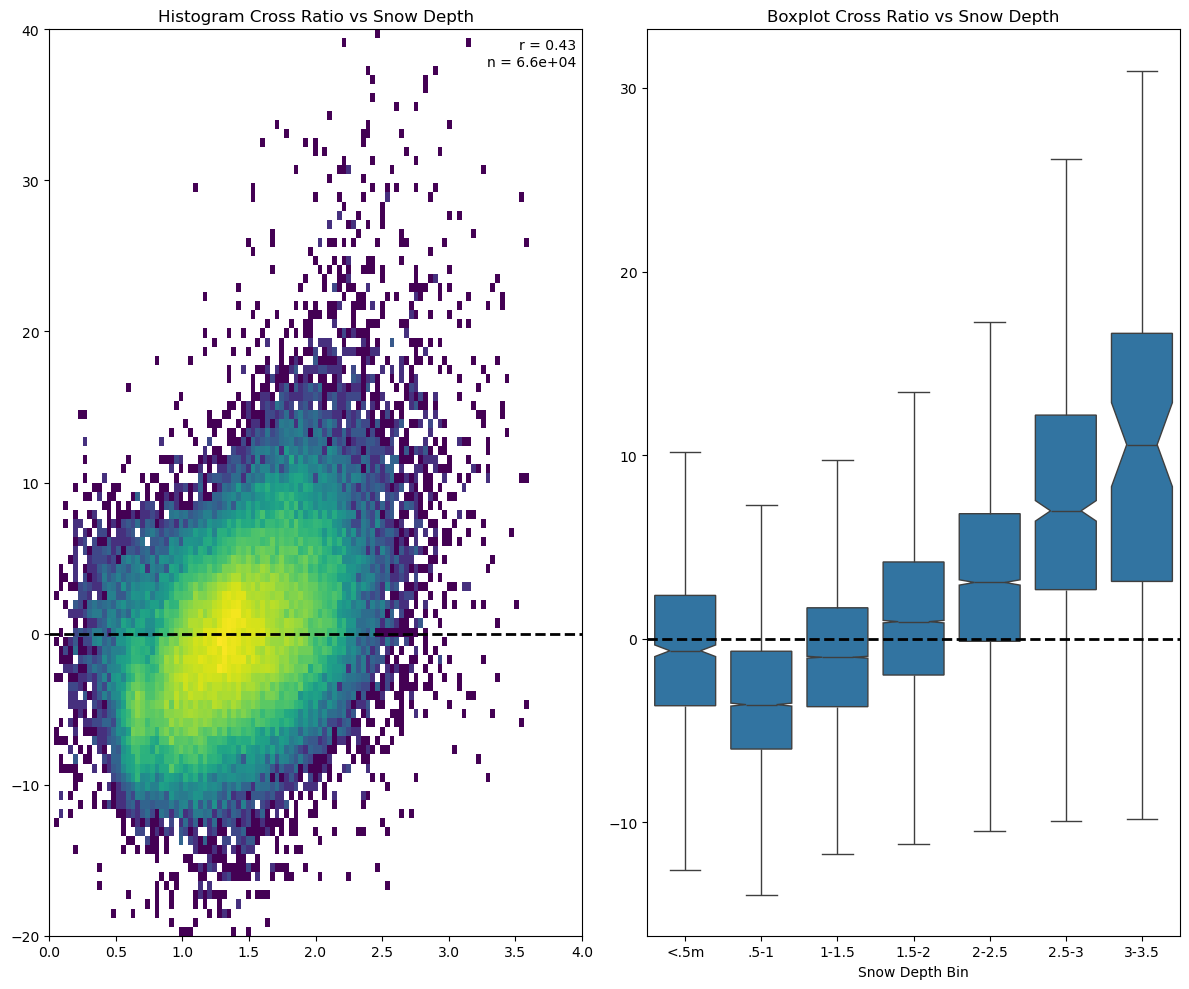

In [6]:
loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}


in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
in_dir = Path('/Users/rdcrlzh1/Documents/spicy-analysis/data/SnowEx-Data')
dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

fig, axes = plt.subplots(1, 2, figsize= (12, 10))

ax4, ax6 = axes

xs, ys = [], []
for name, ds in dss.items():
    x = ds['lidar-sd'].data.ravel()
    y = ds['deltaCR'].where((ds['ims'] == 4)).sum(['time']).data.ravel()
    idx = ~np.isnan(x) & ~np.isnan(y) & (y != 0)
    x, y = x[idx], y[idx]
    xs.extend(x)
    ys.extend(y)

r = get_stats(xs, ys)[0]
n = len(xs)
ax4.text(.99, .99, f'r = {r:.2f}\nn = {n:.1e}', ha = 'right', va = 'top', transform = ax4.transAxes)
ax4.hist2d(xs, ys, alpha = 1, label = name.split('-')[0], norm = mpl.colors.LogNorm(), bins=100, range = [[0,3.6], [-20, 40]]) # , color = loc_colors[name],
ax4.set_xlim(right = 4)
ax4.set_title('Histogram Cross Ratio vs Snow Depth')
ax4.axhline(0, linestyle ='dashed',color='k', linewidth = 2)

x_y_df = pd.DataFrame(np.column_stack([xs, ys]), columns = ['snow_depth', 'CR'])
bins = np.arange(0, 4, 0.5)
x_y_df['sd_bin'] = pd.cut(x_y_df.snow_depth, bins, labels = ['<.5m', '.5-1', '1-1.5', '1.5-2','2-2.5','2.5-3','3-3.5'])
sns.boxplot(x_y_df, x = 'sd_bin', y = 'CR', ax = ax6, showmeans = False, showfliers = False, notch = True)
kwargs = {'alpha':0}
# sns.barplot(x="sd_bin", y="CR", data=x_y_df, capsize=.1, n_boot=1000, errorbar=('ci', 95), errwidth=2,ax = ax6, **kwargs)
ax6.axhline(0, linestyle ='dashed',color='k', linewidth = 2)
ax6.set_title('Boxplot Cross Ratio vs Snow Depth')
ax6.set_ylabel('')
ax6.set_xlabel('Snow Depth Bin')

plt.tight_layout()
# plt.savefig('/bsuhome/zacharykeskinen/spicy-analysis/figures/cr/banner2021_cr.png')

In [19]:
res = pd.DataFrame()
all_pixels = 0
all_dry_pixel = 0
for stem, ds in dss.items():
    if stem == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
    site_name = stem.replace('_', ' ').split('-')[0].replace('Little Cottonwood', 'LCC').replace('Frasier', 'Fraser')

    x, y = ds['snow_depth'].sel(time = im_date, method = 'nearest'), ds['lidar-sd']
    pxl_cnt = (~np.isnan(x)) & (~np.isnan(y))

    x, y = ds['snow_depth'].sel(time = im_date, method = 'nearest'), ds['lidar-sd']
    x = x.where(ds['wet_snow'].sel(time = im_date, method = 'nearest') == 0)
    dry_pxl_cnt = (~np.isnan(x)) & (~np.isnan(y))

    res.loc[site_name, 'valid_pixels'] = pxl_cnt.sum().data.ravel()[0]
    res.loc[site_name, 'valid_dry_pixels'] = dry_pxl_cnt.sum().data.ravel()[0]
res.loc['all', ['valid_pixels', 'valid_dry_pixels']] = res.sum(axis = 0).values
res

,valid_pixels,valid_dry_pixels
Mores 2021,3813.0,581.0
Fraser 2021,6787.0,211.0
Dry Creek 2020,3792.0,1001.0
Banner 2021,16692.0,2531.0
Cameron 2021,2378.0,170.0
Banner 2020,16415.0,2571.0
Mores 2020,3694.0,1530.0
LCC 2021,2827.0,1045.0
Fraser 2020,3847.0,184.0
all,60245.0,9824.0


/var/folders/hn/hd92_2tj7rj8xghqt1qf0nhr2p1n49/T/ipykernel_75648/1355926399.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax6.set_xticklabels(new_labels)


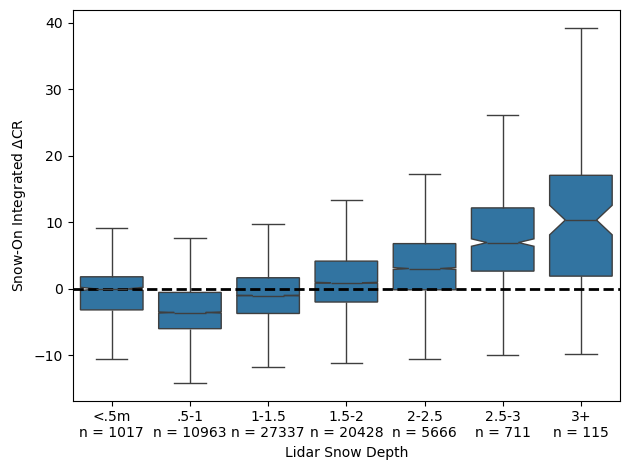

In [22]:
fig, ax6 = plt.subplots()
xs, ys = [], []
for name, ds in dss.items():
    # ds = ds.where(ds['fcf'] < 0.5)
    x = ds['lidar-sd'].data.ravel()
    y = ds['deltaCR'].where((ds['ims'] == 4)).sum(['time']).data.ravel()
    idx = ~np.isnan(x) & ~np.isnan(y) #& (y != 0)
    x, y = x[idx], y[idx]
    xs.extend(x)
    ys.extend(y)

x_y_df = pd.DataFrame(np.column_stack([xs, ys]), columns = ['snow_depth', 'CR'])
bins = np.arange(0, 4, 0.5)
bins[-1] = 6
# bins = [0, 0.5, 1, 1.5, 2, 2.5, 6]
x_y_df['sd_bin'] = pd.cut(x_y_df.snow_depth, bins, labels = ['<.5m', '.5-1', '1-1.5', '1.5-2','2-2.5','2.5-3', '3+'])
sns.boxplot(x_y_df, x = 'sd_bin', y = 'CR', ax = ax6, showmeans = False, showfliers = False, notch = True)
kwargs = {'alpha':0}
# sns.barplot(x="sd_bin", y="CR", data=x_y_df, capsize=.1, n_boot=1000, errorbar=('ci', 95), errwidth=2,ax = ax6, **kwargs)
ax6.axhline(0, linestyle ='dashed',color='k', linewidth = 2)
# ax6.set_title('Cross Ratio vs Snow Depth')
ax6.set_ylabel('Snow-On Integrated $\Delta$CR')
ax6.set_xlabel('Lidar Snow Depth')
components = list(zip([lab.get_text() for lab in ax6.get_xticklabels()],x_y_df['sd_bin'].dropna().value_counts(sort = False).values))
new_labels = [l[0]+f'\nn = {l[1]}' for l in components]
ax6.set_xticklabels(new_labels)



plt.tight_layout()